In [1]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
import numpy as np

mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.target = mnist.target.astype(np.uint8)

X = mnist["data"]
y = mnist["target"]

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [ ]:
import matplotlib.pyplot as plt
import matplotlib as mpl

# Extra code for plotting digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

**Choosing the Right Number of Dimensions**

In [ ]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

pca.n_components_

154

In [ ]:
pca.explained_variance_ratio_

**PCA for Compression**

In [ ]:
#pca = PCA(n_components=154)
pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = pca.fit_transform(X_train)

#Reconstruction
X_recovered = pca.inverse_transform(X_reduced)

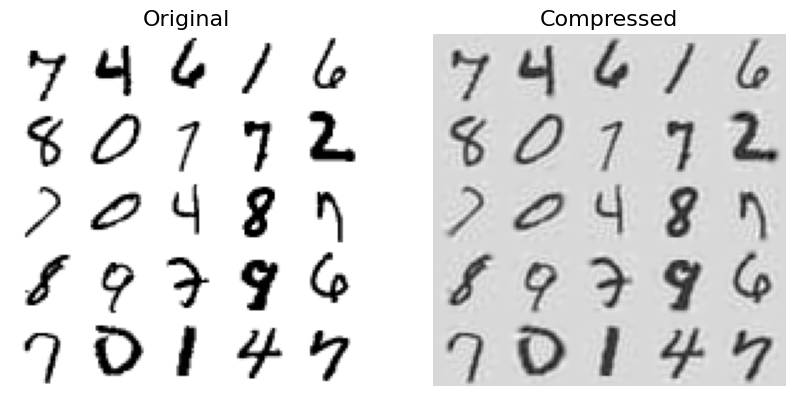

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered[::2100])
plt.title("Compressed", fontsize=16)

plt.show()

**Incremental PCA**

In [ ]:
from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)

for X_batch in np.array_split(X_train, n_batches):
  inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

X_recovered_inc_pca = inc_pca.inverse_transform(X_reduced)

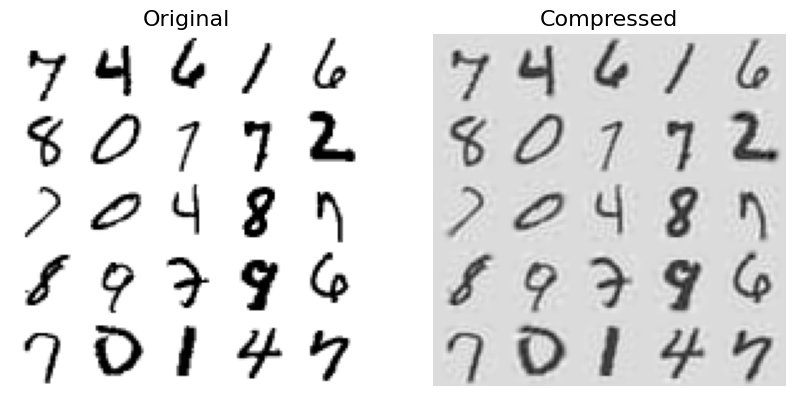

In [ ]:
plt.figure(figsize=(10, 6))
plt.subplot(121)
plot_digits(X_train[::2100])
plt.title("Original", fontsize=16)
plt.subplot(122)
plot_digits(X_recovered_inc_pca[::2100])
plt.title("Compressed", fontsize=16)

plt.show()

**Kernel PCA**

In [ ]:
from sklearn.decomposition import KernelPCA
from sklearn.datasets import make_swiss_roll

X, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

lin_pca = KernelPCA(n_components = 2, kernel="linear", fit_inverse_transform=True)
rbf_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.035, fit_inverse_transform=True)
sig_pca = KernelPCA(n_components = 2, kernel="sigmoid", gamma=0.001, coef0=1, fit_inverse_transform=True)

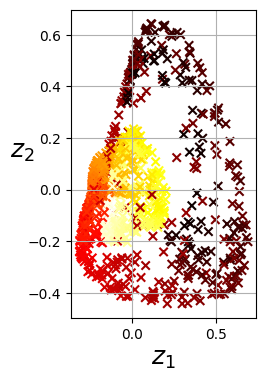

In [ ]:
X_reduced = rbf_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(141)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

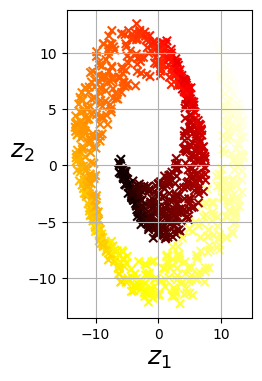

In [ ]:
X_reduced = lin_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(142)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

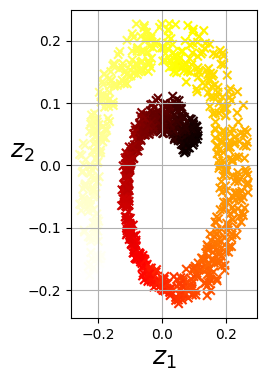

In [ ]:
X_reduced = sig_pca.fit_transform(X)

plt.figure(figsize=(11, 4))
plt.subplot(143)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot, marker="x")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)

**Selecting a Kernel and Tuning Hyperparameters**

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

y = t > 6.9

clf = Pipeline([
("kpca", KernelPCA(n_components=2)),
("log_reg", LogisticRegression())
])

param_grid = [{
"kpca__gamma": np.linspace(0.03, 0.05, 10),
"kpca__kernel": ["rbf", "sigmoid"]
}]

grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X, y)

print(grid_search.best_params_)

{'kpca__gamma': 0.043333333333333335, 'kpca__kernel': 'rbf'}


In [ ]:
from sklearn.metrics import mean_squared_error

best_pca = KernelPCA(n_components = 2, kernel="rbf", gamma=0.0433,
                    fit_inverse_transform=True)

X_reduced = best_pca.fit_transform(X)
X_preimage = best_pca.inverse_transform(X_reduced)

mean_squared_error(X, X_preimage)

32.78630879576617

**LLE**

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_reduced = lle.fit_transform(X)

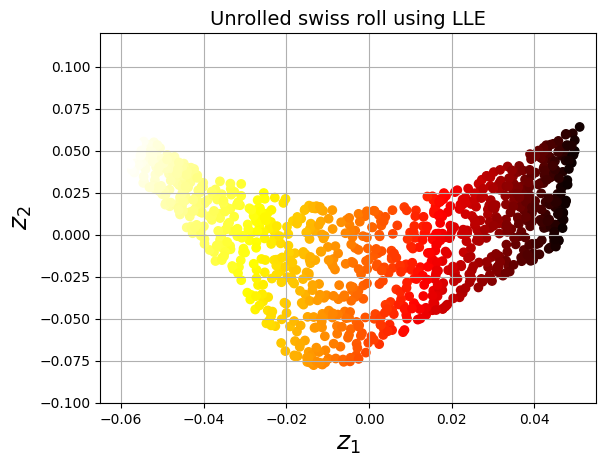

In [ ]:
plt.title("Unrolled swiss roll using LLE", fontsize=14)
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=plt.cm.hot)
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18)
plt.axis([-0.065, 0.055, -0.1, 0.12])
plt.grid(True)

plt.show()